<a href="https://colab.research.google.com/github/jamespaultg/NLP_EDA/blob/master/0_0_eda_nlp_million_headlines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Exploratory Data Analysis for Text**
Credits: https://ui.neptune.ai/neptune-ai/eda-nlp-tools/notebooks?notebookId=f42d5ffd-0a6c-47f5-8cb8-bcddc93bf5e7

https://opendatascience.com/exploratory-data-analysis-for-natural-language-processing-a-complete-guide-to-python-tools/?utm_campaign=Learning%20Posts&utm_content=126886257&utm_medium=social&utm_source=linkedin&hss_channel=lcp-9358547


### Importing Required Libraries

In [1]:
!pip install pyLDAvis -q
!pip install textstat -q

     |████████████████████████████████| 1.6MB 2.6MB/s 
     |████████████████████████████████| 552kB 9.6MB/s 
     |████████████████████████████████| 102kB 2.2MB/s 
     |████████████████████████████████| 3.0MB 7.4MB/s 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer
import gensim
from collections import  Counter
import string
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from spacy import displacy
import nltk

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [16, 12]})
plt.style.use('seaborn-whitegrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Importing data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
news= pd.read_csv('/content/drive/My Drive/NLP deep dive/NLP EDA/data/abcnews-date-text.csv',nrows=1000)
news.head(3)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit


# Text statistics

### Number of characters present in each sentence

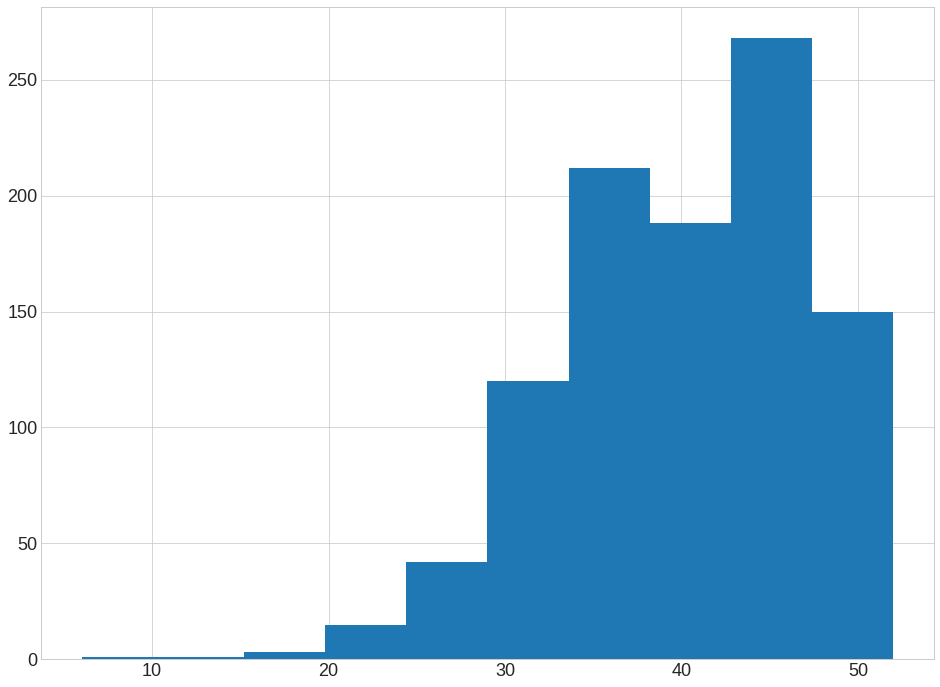

In [5]:
news['headline_text'].str.len().hist()

### number of words appearing in each news headline.


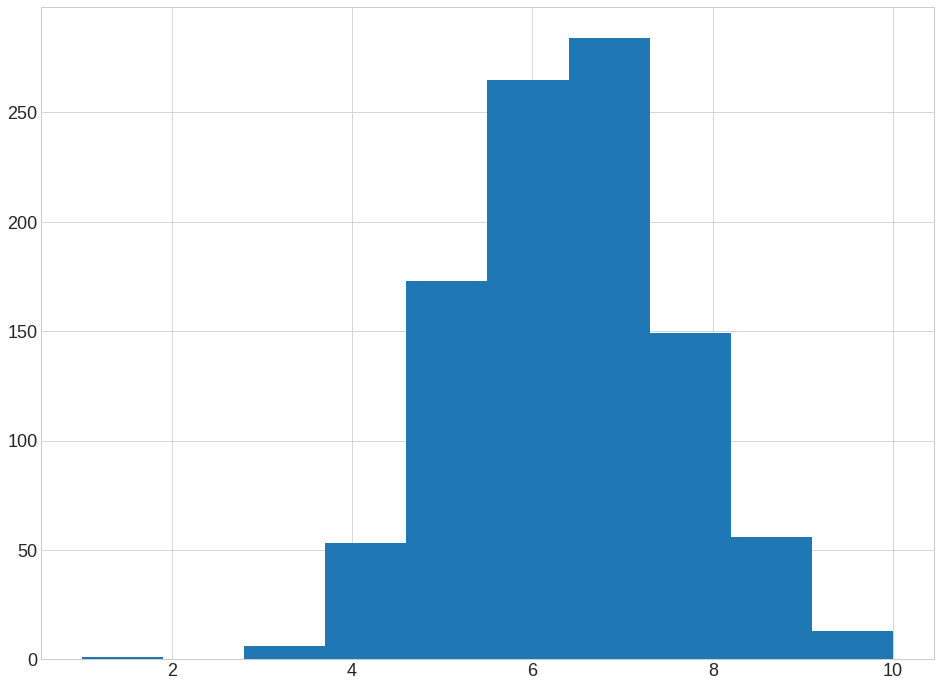

In [6]:
news['headline_text'].str.split().map(lambda x: len(x)).hist()

### Analysing word length

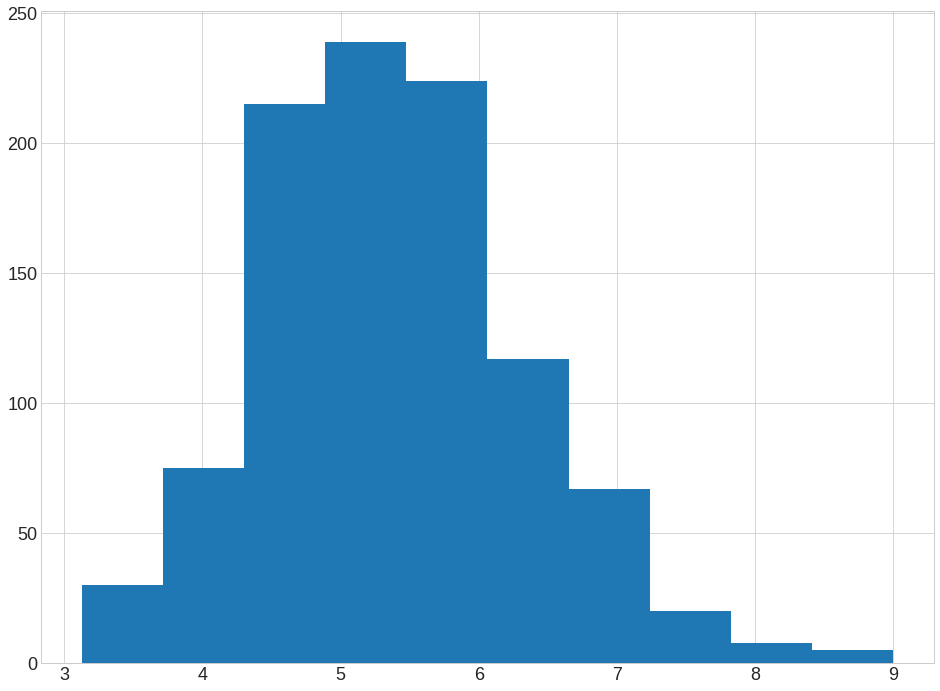

In [7]:
news['headline_text'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

### Analysing stopwords

In [8]:
# Fetch stopwords
import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Create corpus
corpus=[]
new= news['headline_text'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

<BarContainer object of 10 artists>

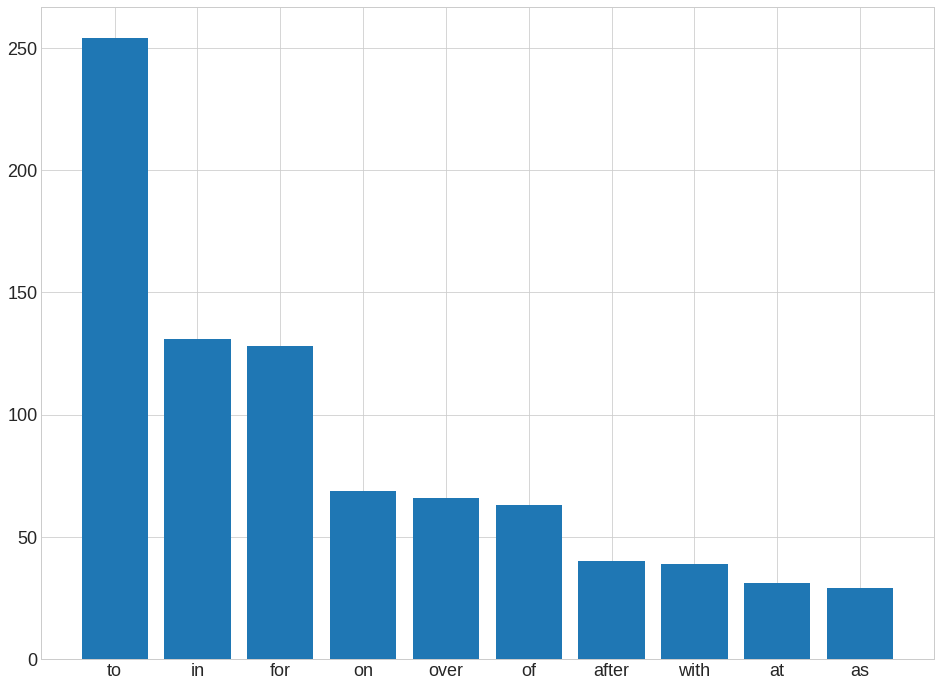

In [10]:
# Plot top stopwords

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

### Most common words

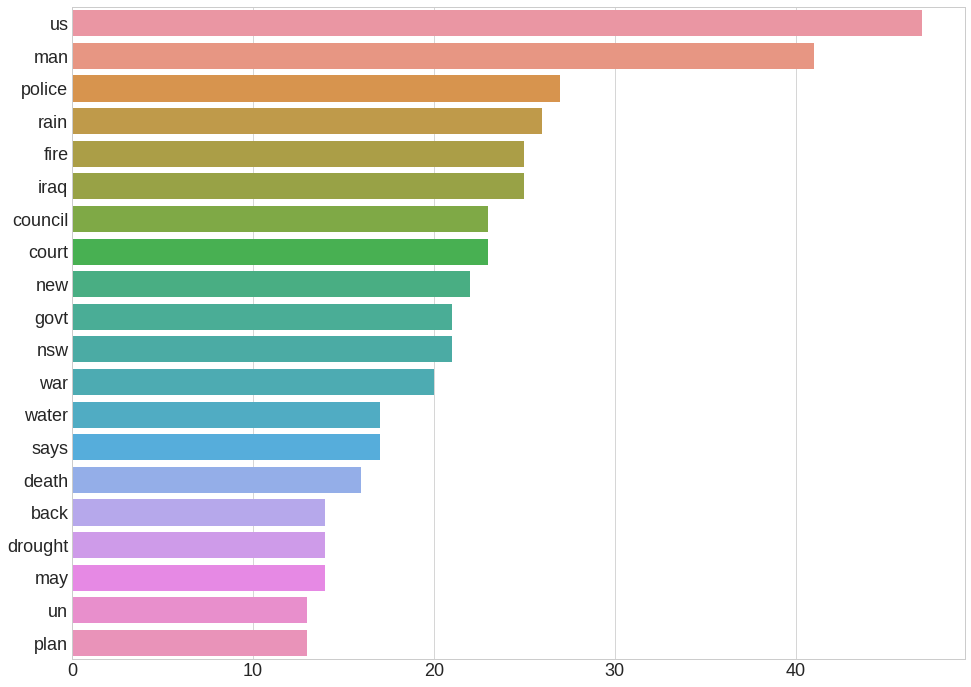

In [11]:
counter=Counter(corpus)
most=counter.most_common()

x, y=[], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

#  Ngram analysis

### Bigram analysis

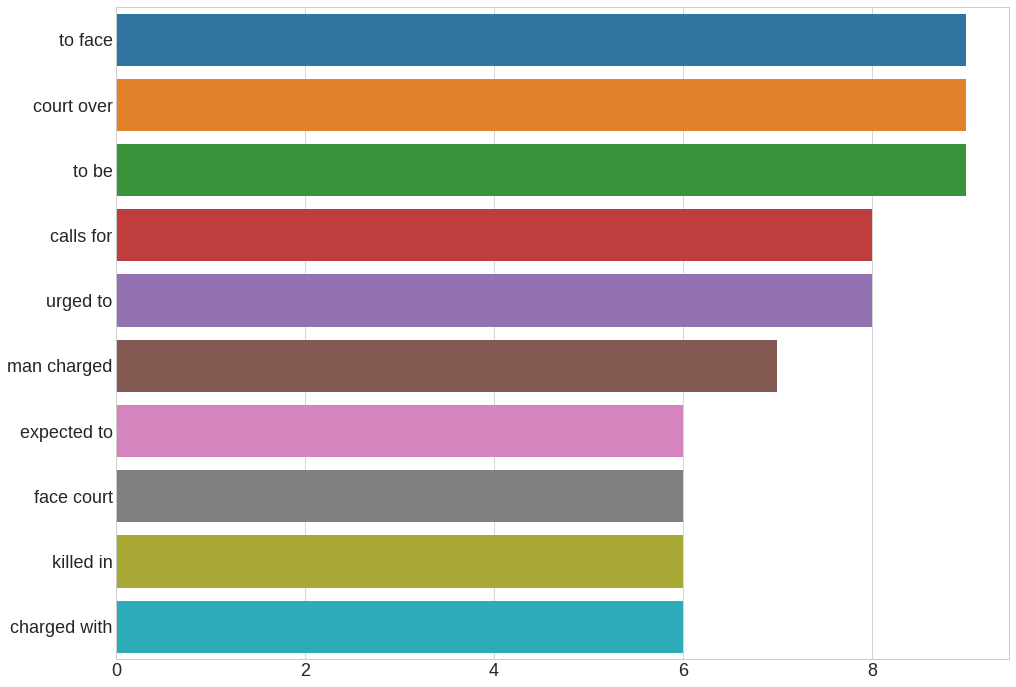

In [12]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

top_n_bigrams=get_top_ngram(news['headline_text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

### Trigram analysis

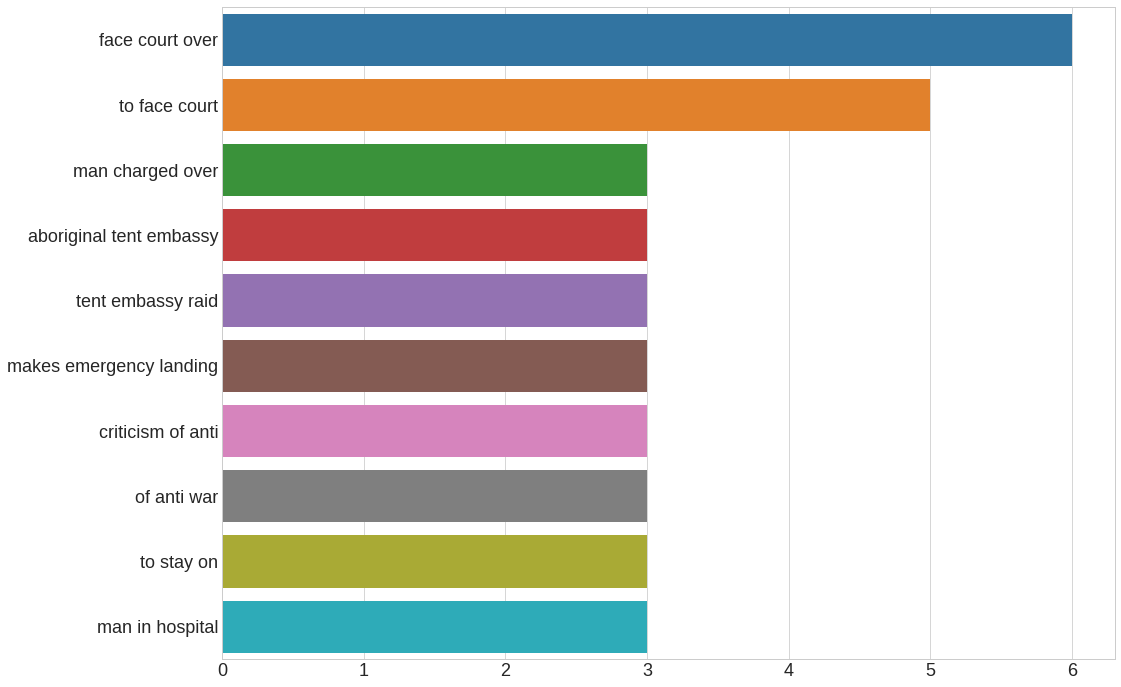

In [13]:
top_tri_grams=get_top_ngram(news['headline_text'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

# Topic modelling

In [14]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['headline_text']:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
corpus=preprocess_news(news)

In [0]:
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [17]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)

Streaming output truncated to the last 5000 lines.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Us

In [18]:
lda_model.show_topics()

[(0,
  '0.007*"call" + 0.007*"rain" + 0.006*"may" + 0.006*"fund" + 0.005*"council" + 0.004*"race" + 0.004*"group" + 0.004*"action" + 0.004*"talk" + 0.004*"govt"'),
 (1,
  '0.009*"nsw" + 0.008*"police" + 0.008*"claim" + 0.006*"back" + 0.005*"drought" + 0.004*"man" + 0.004*"murder" + 0.004*"warne" + 0.004*"pay" + 0.003*"raid"'),
 (2,
  '0.014*"man" + 0.006*"face" + 0.006*"police" + 0.005*"death" + 0.005*"turkey" + 0.005*"patterson" + 0.004*"probe" + 0.004*"crash" + 0.004*"plane" + 0.004*"attack"'),
 (3,
  '0.009*"new" + 0.008*"fire" + 0.007*"plan" + 0.007*"iraq" + 0.007*"council" + 0.006*"say" + 0.005*"war" + 0.005*"iraqi" + 0.005*"offer" + 0.005*"win"')]

### Visualize the topics


In [19]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.095998 -0.066943       1        1  27.223745
2      0.116331 -0.053673       2        1  26.731373
1     -0.000974  0.117072       3        1  24.899174
0     -0.019359  0.003545       4        1  21.145712, topic_info=       Term       Freq      Total Category  logprob  loglift
275  police  19.000000  19.000000  Default  30.0000  30.0000
437     new  15.000000  15.000000  Default  29.0000  29.0000
422   claim  15.000000  15.000000  Default  28.0000  28.0000
199     nsw  14.000000  14.000000  Default  27.0000  27.0000
317     man  30.000000  30.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
28      win   3.081064  12.965984   Topic4  -5.8615   0.1167
214   still   2.810492   8.800612   Topic4  -5.9534   0.4123
317     man   3.286847  30.170820   Topic4  -5.7969  -0.6632
299  health   2.391806   7.473501   Topic4  -6.1147   0.4144
588    anti   2.267330   7.504097   Topic4  -6.1682   0.3569

[273 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
372       3  0.733745  aboriginal
5         1  0.641955         act
5         2  0.320978         act
610       1  0.271557      action
610       4  0.678891      action
...     ...       ...         ...
738       1  0.965826    williams
28        1  0.539874         win
28        3  0.231375         win
28        4  0.231375         win
812       4  0.501283        wind

[380 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

# Wordclouds

In [0]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1 
        )
    
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

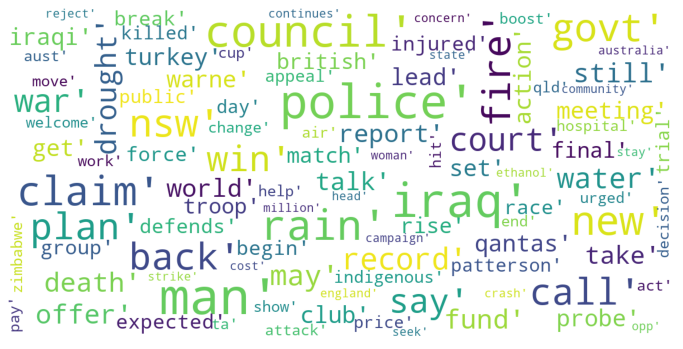

In [21]:
show_wordcloud(corpus)

# Text sentiment

In [22]:
from textblob import TextBlob
TextBlob('100 people killed in Iraq').sentiment

Sentiment(polarity=-0.2, subjectivity=0.0)

### Textblob

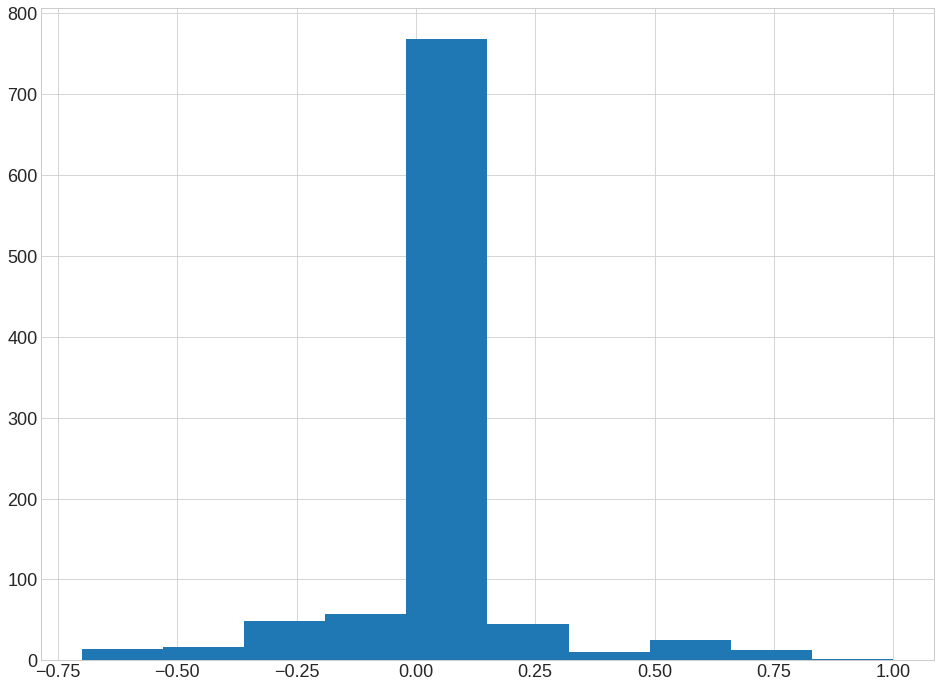

In [23]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score']=news['headline_text'].\
   apply(lambda x : polarity(x))
news['polarity_score'].hist()

### Postive , Negative or Neutral ?

In [0]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
news['polarity']=news['polarity_score'].\
   map(lambda x: sentiment(x))

<BarContainer object of 3 artists>

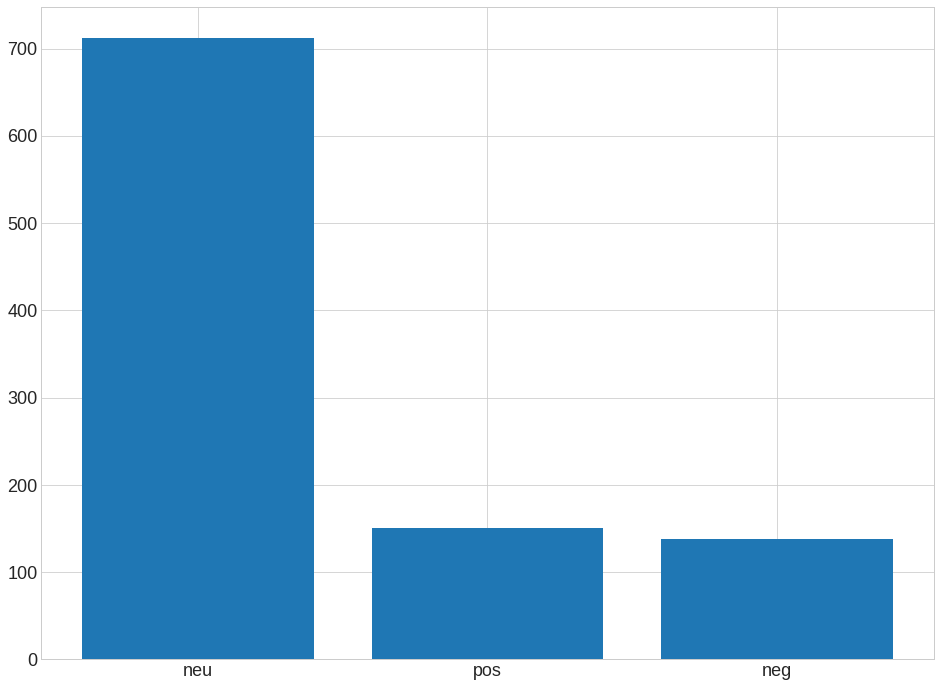

In [25]:
plt.bar(news.polarity.value_counts().index,
        news.polarity.value_counts())

In [26]:
news[news['polarity']=='neg']['headline_text'].head(5)

7     aussie qualifier stosur wastes four memphis match
23               carews freak goal leaves roma in ruins
28     council chief executive fails to secure position
34                   dargo fire threat expected to rise
40        direct anger at govt not soldiers crean urges
Name: headline_text, dtype: object

### Vader

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
news['polarity']=news['headline_text'].\
    map(lambda x: get_vader_score(x))
polarity=news['polarity'].replace({0:'neg',1:'neu',2:'pos'})

<BarContainer object of 3 artists>

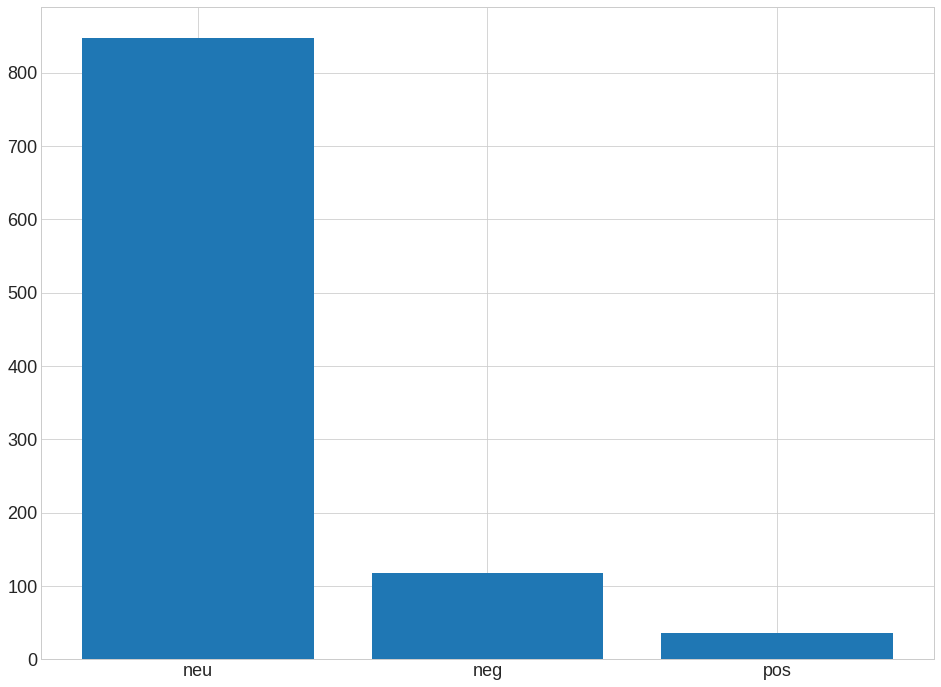

In [29]:
plt.bar(polarity.value_counts().index,
        polarity.value_counts())

# Named Entity Recognition

In [0]:
# !python -m spacy download en_core_web_sm

In [31]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

doc=nlp('India and Iran have agreed to boost the economic \
viability of the strategic Chabahar port through various measures, \
including larger subsidies to merchant shipping firms using the facility, \
people familiar with the development said on Thursday.')

[(x.text,x.label_) for x in doc.ents]

[('India', 'GPE'),
 ('Iran', 'GPE'),
 ('Chabahar', 'PERSON'),
 ('Thursday', 'DATE')]

In [32]:
from spacy import displacy

displacy.render(doc, style='ent')

'<div class="entities" style="line-height: 2.5; direction: ltr">\n<mark class="entity" style="background: #feca74; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    India\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">GPE</span>\n</mark>\n and \n<mark class="entity" style="background: #feca74; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    Iran\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">GPE</span>\n</mark>\n have agreed to boost the economic viability of the strategic \n<mark class="entity" style="background: #aa9cfc; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    Chabahar\n    <span style="font-size: 0.8em; font-weight: bold; line-h

### NER Analysis

In [0]:
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

In [0]:
ent=news['headline_text'].apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]
counter=Counter(ent)
count=counter.most_common()

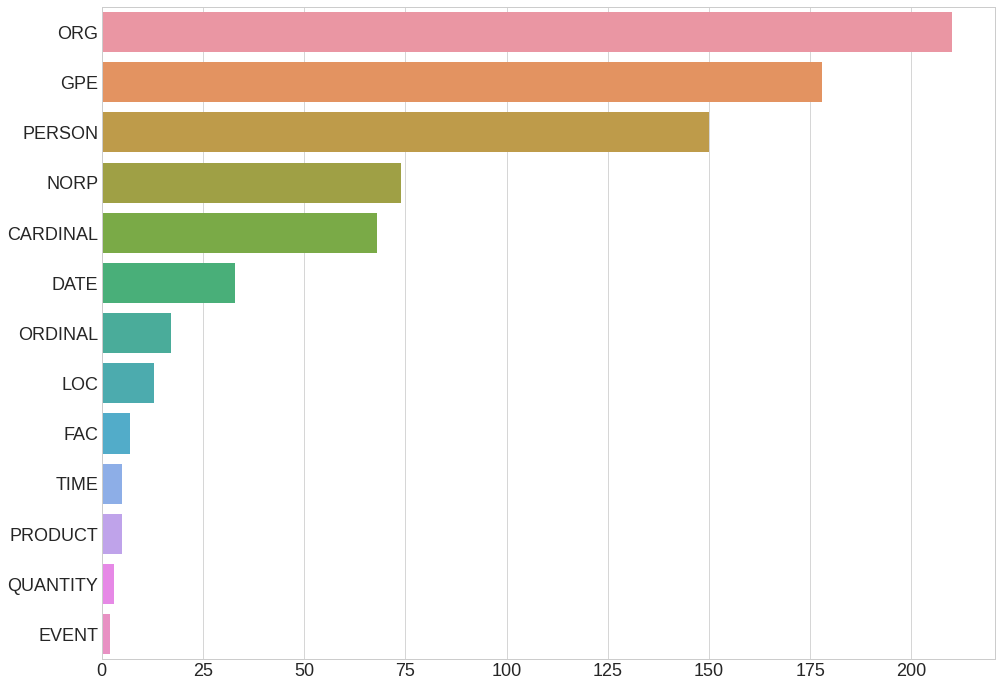

In [35]:
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

### Most common GPE

In [0]:
def ner(text,ent="GPE"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

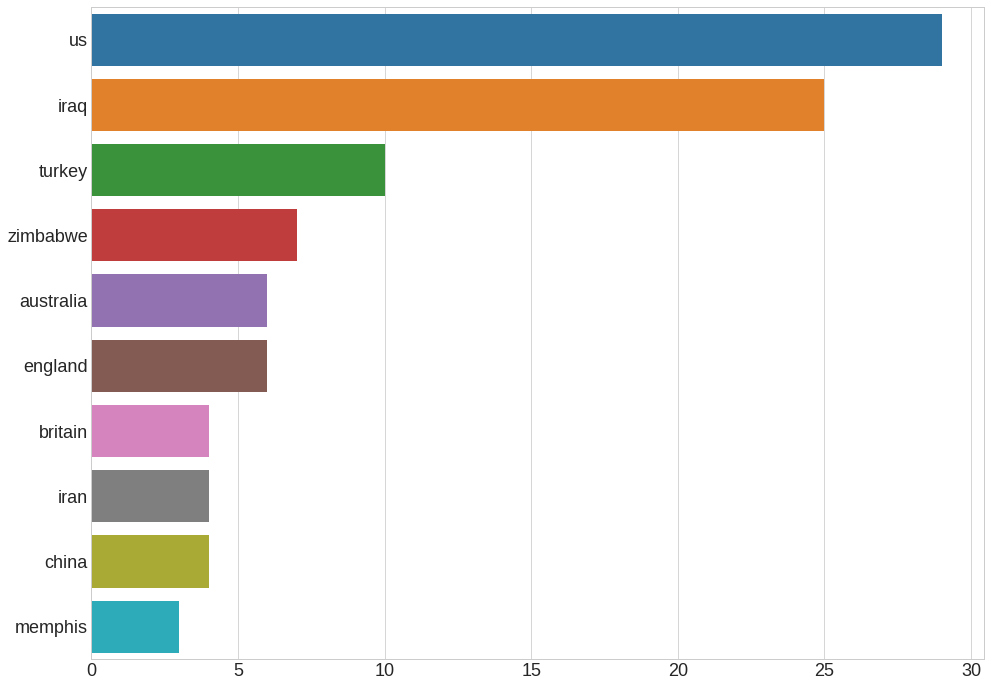

In [37]:
gpe=news['headline_text'].apply(lambda x: ner(x,"GPE"))
gpe=[i for x in gpe for i in x]
counter=Counter(gpe)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

### Most common person

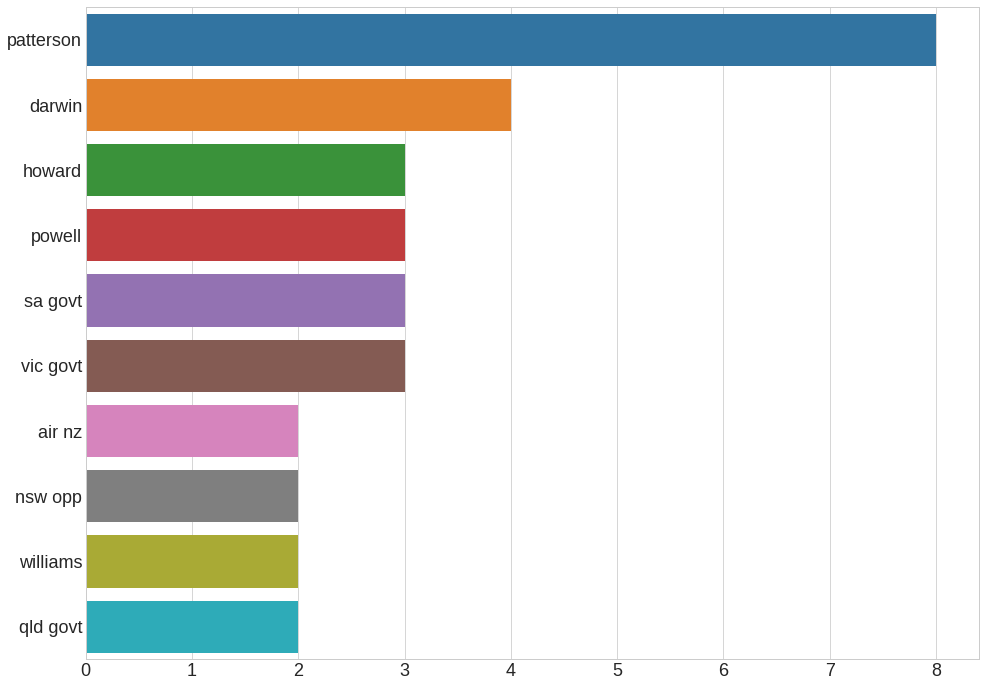

In [38]:
per=news['headline_text'].apply(lambda x: ner(x,"PERSON"))
per=[i for x in per for i in x]
counter=Counter(per)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

# Pos tagging

In [39]:
import nltk
nltk.download('averaged_perceptron_tagger')

sentence="The greatest comeback stories in 2019"
tokens=word_tokenize(sentence)
nltk.pos_tag(tokens)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('The', 'DT'),
 ('greatest', 'JJS'),
 ('comeback', 'NN'),
 ('stories', 'NNS'),
 ('in', 'IN'),
 ('2019', 'CD')]

In [40]:
doc = nlp('The greatest comeback stories in 2019')
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

In [41]:
import nltk
nltk.download('averaged_perceptron_tagger')

sentence="she sells seashells"
tokens=word_tokenize(sentence)
nltk.pos_tag(tokens)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('she', 'PRP'), ('sells', 'VBZ'), ('seashells', 'NNS')]

### Analysing pos tags

In [0]:
def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

In [0]:
tags=news['headline_text'].apply(lambda x : pos(x))
tags=[x for l in tags for x in l]
counter=Counter(tags)
x,y=list(map(list,zip(*counter.most_common(7))))

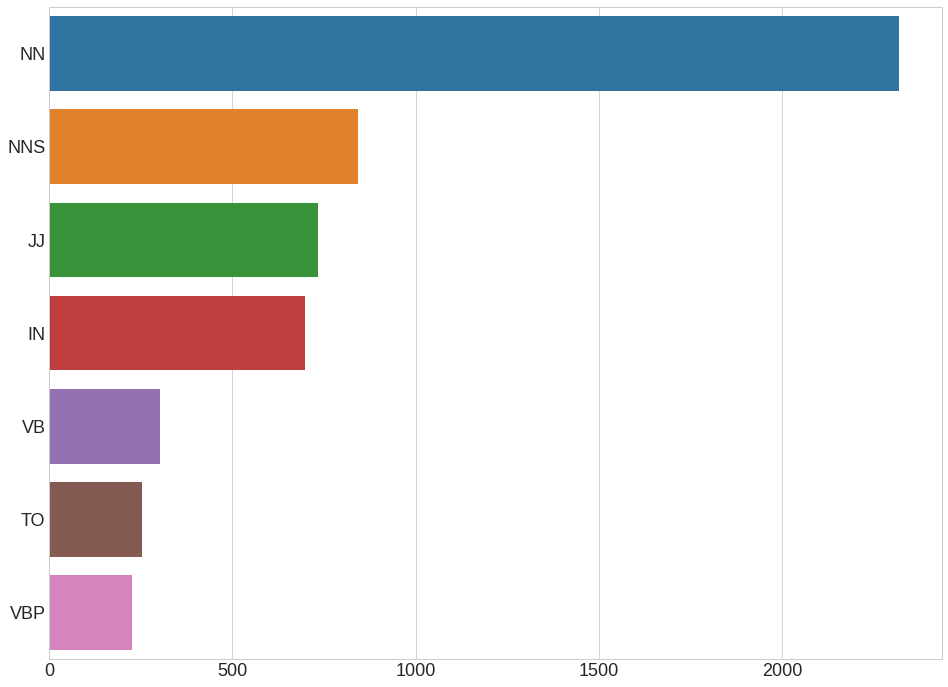

In [44]:
sns.barplot(x=y,y=x)

### Most common Nouns

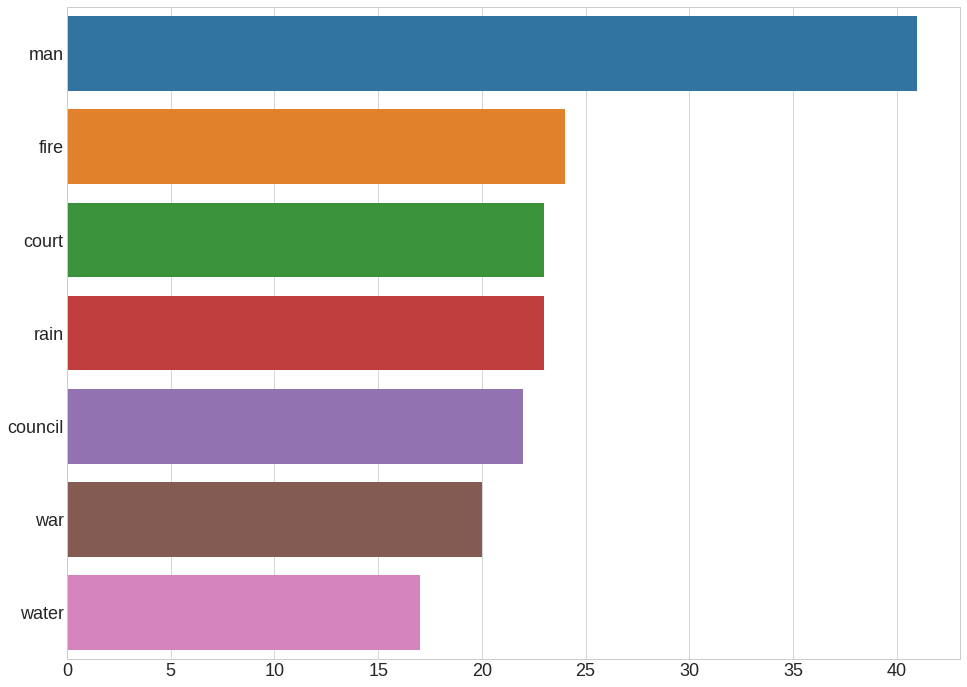

In [45]:
def get_adjs(text):
    adj=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag=='NN':
            adj.append(word)
    return adj


words=news['headline_text'].apply(lambda x : get_adjs(x))
words=[x for l in words for x in l]
counter=Counter(words)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

### dependency graph

In [46]:
doc = nlp('She sells seashells by  the seashore')
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

# Text readability

### Textstat

In [0]:
from textstat import flesch_reading_ease

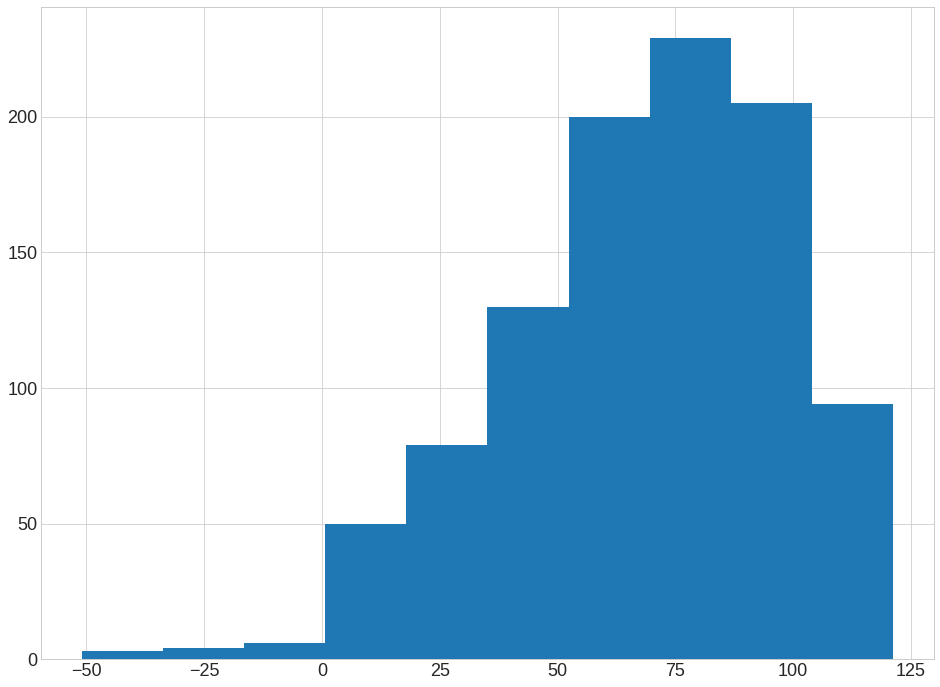

In [48]:
news['headline_text'].\
apply(lambda x : flesch_reading_ease(x)).hist()

### Complex headlines?

In [49]:
x=[i for i in range(len(reading)) if reading[i]<5]

NameError: ignored

In [0]:
news.iloc[x]['headline_text'].head()